# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [5]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm)),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 1, 2, 3, 4, 6, 7, 8, 9] rm: [5]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.236
[2] loss: 0.146
[3] loss: 0.048
[4] loss: 0.025
[5] loss: 0.016
[6] loss: 0.011
[7] loss: 0.012
[8] loss: 0.008
[9] loss: 0.007
[10] loss: 0.005
[11] loss: 0.006
[12] loss: 0.006
[13] loss: 0.004
[14] loss: 0.003
[15] loss: 0.004
[16] loss: 0.003
[17] loss: 0.002
[18] loss: 0.002
[19] loss: 0.004
[20] loss: 0.004


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

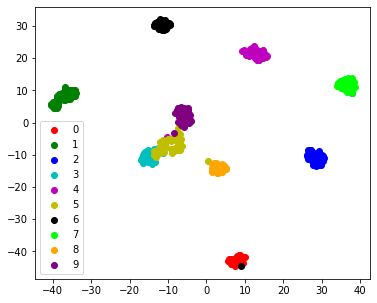

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

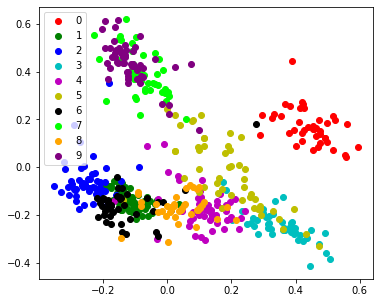

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm), y_dim))
cs = np.zeros(10 - len(rm))
covs = np.zeros((10 - len(rm), y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm), y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.4225, -0.1141, -0.2341,  0.3578,  0.1150, -0.1392, -0.0604,  0.0339,
         -0.1238],
        [-0.1984, -0.2086, -0.2450, -0.0924,  0.4027,  0.3145, -0.1671,  0.7278,
          0.2187],
        [ 0.1624, -0.1260, -0.0600, -0.2477, -0.1750, -0.1563,  0.3778, -0.1739,
          0.4539],
        [-0.2675, -0.1888,  0.5444,  0.3784,  0.2993, -0.1602, -0.2081, -0.2360,
          0.3224],
        [ 0.2974,  0.2127,  0.5285, -0.2233, -0.2052, -0.0892, -0.0285,  0.4414,
         -0.1461],
        [-0.1970, -0.2159, -0.0739,  0.4432, -0.2384,  0.5380,  0.4495, -0.1626,
         -0.2006],
        [ 0.0975,  0.4291, -0.2161, -0.2735, -0.2033,  0.3895, -0.2409, -0.2139,
          0.2060],
        [-0.1476,  0.4588, -0.0997, -0.1223,  0.7408, -0.1524,  0.3407, -0.1151,
         -0.1171]])

In [13]:
f1 = nn.Linear(10 - len(rm), y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm)):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm), 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm), 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_5.cfg')

['./config/sswae_dev2_rm_5.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 5
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : False
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_b

[default |INFO|model.py:1823] [01/80]  loss: 2.416903e-01  D: 6.903624e-01  D2: 5.295655e-02  D3: 3.356471e-03
test loss: 1.828646e-01  D: 6.932456e-01  D2: 3.248408e-02  D3: 6.025777e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.690970e-01  D: 6.932099e-01  D2: 2.382348e-02  D3: 6.480387e-03
test loss: 1.576963e-01  D: 6.932071e-01  D2: 1.580356e-02  D3: 7.616285e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.546382e-01  D: 6.944941e-01  D2: 8.414734e-03  D3: 8.514985e-03
test loss: 1.452660e-01  D: 6.665767e-01  D2: 5.901316e-03  D3: 1.339350e-02


[default |INFO|model.py:1823] [04/80]  loss: 1.365790e-01  D: 6.962474e-01  D2: 3.688364e-03  D3: 1.219830e-02
test loss: 1.229848e-01  D: 7.251801e-01  D2: 2.086257e-03  D3: 1.154518e-02


[default |INFO|model.py:1823] [05/80]  loss: 1.155395e-01  D: 6.973011e-01  D2: 1.416786e-03  D3: 1.315022e-02
test loss: 1.052689e-01  D: 7.075363e-01  D2: -3.611791e-04  D3: 1.350889e-02


[default |INFO|model.py:1823] [06/80]  loss: 9.939027e-02  D: 6.938863e-01  D2: -4.883915e-04  D3: 1.446892e-02
test loss: 9.322794e-02  D: 6.967542e-01  D2: -1.961456e-03  D3: 1.453713e-02


[default |INFO|model.py:1823] [07/80]  loss: 8.938369e-02  D: 6.944190e-01  D2: -1.855658e-03  D3: 1.441997e-02
test loss: 8.540510e-02  D: 6.987071e-01  D2: -2.377082e-03  D3: 1.507424e-02


[default |INFO|model.py:1823] [08/80]  loss: 8.258861e-02  D: 6.945497e-01  D2: -2.669760e-03  D3: 1.469657e-02
test loss: 7.977316e-02  D: 7.217464e-01  D2: -3.321581e-03  D3: 1.779052e-02


[default |INFO|model.py:1823] [09/80]  loss: 7.770056e-02  D: 6.938958e-01  D2: -3.429091e-03  D3: 1.451003e-02
test loss: 7.404438e-02  D: 6.758135e-01  D2: -4.114096e-03  D3: 1.473083e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.550540e-02  D: 6.944016e-01  D2: -3.829529e-03  D3: 1.408126e-02
test loss: 7.176869e-02  D: 7.178234e-01  D2: -3.760246e-03  D3: 1.361248e-02


[default |INFO|model.py:1823] [11/80]  loss: 7.082144e-02  D: 6.938328e-01  D2: -4.053331e-03  D3: 1.413360e-02
test loss: 6.969905e-02  D: 7.022907e-01  D2: -3.738447e-03  D3: 1.371634e-02


[default |INFO|model.py:1823] [12/80]  loss: 7.053167e-02  D: 6.937791e-01  D2: -3.777009e-03  D3: 1.421434e-02
test loss: 9.764958e-02  D: 6.810015e-01  D2: -3.200502e-03  D3: 1.653907e-02


[default |INFO|model.py:1823] [13/80]  loss: 7.317845e-02  D: 6.948722e-01  D2: -4.366838e-03  D3: 1.417419e-02
test loss: 6.899620e-02  D: 7.128402e-01  D2: -5.041200e-03  D3: 1.481566e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.745919e-02  D: 6.943810e-01  D2: -4.326287e-03  D3: 1.418811e-02
test loss: 6.437350e-02  D: 6.928134e-01  D2: -4.352610e-03  D3: 1.242985e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.766605e-02  D: 6.934113e-01  D2: -4.407690e-03  D3: 1.389457e-02
test loss: 6.856491e-02  D: 6.881715e-01  D2: -5.106570e-03  D3: 1.312135e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.760052e-02  D: 6.949527e-01  D2: -4.410224e-03  D3: 1.282017e-02
test loss: 6.581529e-02  D: 7.037795e-01  D2: -4.769089e-03  D3: 1.373268e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.262604e-02  D: 6.935016e-01  D2: -4.875843e-03  D3: 1.412741e-02
test loss: 6.215244e-02  D: 6.911500e-01  D2: -4.425636e-03  D3: 1.397475e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.117318e-02  D: 6.941483e-01  D2: -5.010825e-03  D3: 1.390505e-02
test loss: 5.905234e-02  D: 6.873466e-01  D2: -4.295760e-03  D3: 1.388956e-02


[default |INFO|model.py:1823] [19/80]  loss: 6.178705e-02  D: 6.945968e-01  D2: -4.915871e-03  D3: 1.350989e-02
test loss: 5.970734e-02  D: 6.868403e-01  D2: -5.125730e-03  D3: 1.393610e-02


[default |INFO|model.py:1823] [20/80]  loss: 6.022701e-02  D: 6.937954e-01  D2: -5.020348e-03  D3: 1.373941e-02
test loss: 5.995377e-02  D: 6.953183e-01  D2: -5.015249e-03  D3: 1.544857e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.791978e-02  D: 6.938558e-01  D2: -5.324325e-03  D3: 1.406469e-02
test loss: 5.823372e-02  D: 6.811309e-01  D2: -4.334351e-03  D3: 1.391290e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.806949e-02  D: 6.941263e-01  D2: -5.244491e-03  D3: 1.412503e-02
test loss: 5.675393e-02  D: 6.970719e-01  D2: -5.322784e-03  D3: 1.386494e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.649484e-02  D: 6.933424e-01  D2: -5.569642e-03  D3: 1.394996e-02
test loss: 5.633189e-02  D: 7.110882e-01  D2: -5.836125e-03  D3: 1.427837e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.596327e-02  D: 6.933266e-01  D2: -5.647798e-03  D3: 1.384675e-02
test loss: 5.595293e-02  D: 6.969996e-01  D2: -5.677564e-03  D3: 1.273822e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.568947e-02  D: 6.934775e-01  D2: -5.820502e-03  D3: 1.380020e-02
test loss: 5.533901e-02  D: 6.909947e-01  D2: -5.375415e-03  D3: 1.413210e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.505402e-02  D: 6.935298e-01  D2: -5.727995e-03  D3: 1.366053e-02
test loss: 5.503368e-02  D: 7.051563e-01  D2: -5.951570e-03  D3: 1.490086e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.433730e-02  D: 6.934859e-01  D2: -6.064399e-03  D3: 1.354440e-02
test loss: 5.572834e-02  D: 6.821344e-01  D2: -6.082867e-03  D3: 1.554719e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.471365e-02  D: 6.938948e-01  D2: -6.214159e-03  D3: 1.321278e-02
test loss: 5.593037e-02  D: 7.073557e-01  D2: -6.433004e-03  D3: 1.255798e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.367582e-02  D: 6.932679e-01  D2: -6.129848e-03  D3: 1.366571e-02
test loss: 5.480388e-02  D: 6.922068e-01  D2: -5.868335e-03  D3: 1.282069e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.318746e-02  D: 6.937163e-01  D2: -6.363482e-03  D3: 1.351076e-02
test loss: 5.605144e-02  D: 7.016031e-01  D2: -6.654543e-03  D3: 1.233452e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.321586e-02  D: 6.931545e-01  D2: -6.586126e-03  D3: 1.339695e-02
test loss: 5.329418e-02  D: 6.905954e-01  D2: -6.230722e-03  D3: 1.428044e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.216637e-02  D: 6.931759e-01  D2: -6.434990e-03  D3: 1.355515e-02
test loss: 5.289465e-02  D: 6.867653e-01  D2: -6.865571e-03  D3: 1.353003e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.251555e-02  D: 6.932808e-01  D2: -6.787246e-03  D3: 1.312823e-02
test loss: 5.515289e-02  D: 6.889854e-01  D2: -6.675651e-03  D3: 1.399628e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.331210e-02  D: 6.934734e-01  D2: -6.798692e-03  D3: 1.313501e-02
test loss: 5.468660e-02  D: 6.913465e-01  D2: -6.020059e-03  D3: 1.353766e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.248552e-02  D: 6.935810e-01  D2: -6.754109e-03  D3: 1.312343e-02
test loss: 5.318345e-02  D: 6.857857e-01  D2: -6.698657e-03  D3: 1.466525e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.318177e-02  D: 6.936694e-01  D2: -7.100473e-03  D3: 1.266093e-02
test loss: 5.264712e-02  D: 6.862129e-01  D2: -6.890111e-03  D3: 1.215004e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.207129e-02  D: 6.931697e-01  D2: -7.103103e-03  D3: 1.312770e-02
test loss: 5.647397e-02  D: 6.917034e-01  D2: -6.827563e-03  D3: 1.344773e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.126672e-02  D: 6.936077e-01  D2: -7.161298e-03  D3: 1.324278e-02
test loss: 5.251999e-02  D: 6.952535e-01  D2: -7.896725e-03  D3: 1.260437e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.141579e-02  D: 6.929911e-01  D2: -7.372126e-03  D3: 1.303198e-02
test loss: 5.295565e-02  D: 6.869906e-01  D2: -7.182541e-03  D3: 1.326091e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.153212e-02  D: 6.939539e-01  D2: -7.237550e-03  D3: 1.287998e-02
test loss: 5.324293e-02  D: 6.853309e-01  D2: -8.026115e-03  D3: 1.419663e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.098755e-02  D: 6.928973e-01  D2: -7.566900e-03  D3: 1.282699e-02
test loss: 5.268511e-02  D: 7.028190e-01  D2: -7.638623e-03  D3: 1.446484e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.161951e-02  D: 6.936757e-01  D2: -7.490107e-03  D3: 1.268467e-02
test loss: 5.187782e-02  D: 6.878554e-01  D2: -7.294330e-03  D3: 1.202786e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.158740e-02  D: 6.937528e-01  D2: -7.561083e-03  D3: 1.251242e-02
test loss: 5.268523e-02  D: 6.834211e-01  D2: -7.502640e-03  D3: 1.374267e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.114940e-02  D: 6.930368e-01  D2: -7.590182e-03  D3: 1.285035e-02
test loss: 5.165260e-02  D: 6.926082e-01  D2: -7.767147e-03  D3: 1.332486e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.107978e-02  D: 6.933328e-01  D2: -7.680434e-03  D3: 1.251928e-02
test loss: 5.222458e-02  D: 6.831350e-01  D2: -7.432683e-03  D3: 1.207288e-02


[default |INFO|model.py:1823] [46/80]  loss: 5.061583e-02  D: 6.935837e-01  D2: -7.842566e-03  D3: 1.249246e-02
test loss: 5.231753e-02  D: 6.860587e-01  D2: -7.859036e-03  D3: 1.298463e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.019208e-02  D: 6.932323e-01  D2: -7.907472e-03  D3: 1.277734e-02
test loss: 5.179548e-02  D: 7.045561e-01  D2: -7.782742e-03  D3: 1.285272e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.074745e-02  D: 6.934768e-01  D2: -7.700161e-03  D3: 1.267453e-02
test loss: 5.143876e-02  D: 6.932045e-01  D2: -8.142898e-03  D3: 1.282732e-02


[default |INFO|model.py:1823] [49/80]  loss: 4.997031e-02  D: 6.933144e-01  D2: -8.080995e-03  D3: 1.248716e-02
test loss: 5.078688e-02  D: 6.914932e-01  D2: -7.969228e-03  D3: 1.329470e-02


[default |INFO|model.py:1823] [50/80]  loss: 5.027644e-02  D: 6.931560e-01  D2: -8.103491e-03  D3: 1.243308e-02
test loss: 5.226855e-02  D: 7.028530e-01  D2: -8.008218e-03  D3: 1.251233e-02


[default |INFO|model.py:1823] [51/80]  loss: 5.075421e-02  D: 6.932443e-01  D2: -8.151599e-03  D3: 1.253142e-02
test loss: 5.233975e-02  D: 6.935713e-01  D2: -8.212408e-03  D3: 1.169974e-02


[default |INFO|model.py:1823] [52/80]  loss: 5.023634e-02  D: 6.936354e-01  D2: -8.134376e-03  D3: 1.244352e-02
test loss: 5.250014e-02  D: 6.930610e-01  D2: -7.869570e-03  D3: 1.268413e-02


[default |INFO|model.py:1823] [53/80]  loss: 5.004830e-02  D: 6.933859e-01  D2: -8.086217e-03  D3: 1.256622e-02
test loss: 5.143257e-02  D: 6.977161e-01  D2: -8.415128e-03  D3: 1.148183e-02


[default |INFO|model.py:1823] [54/80]  loss: 4.962208e-02  D: 6.933299e-01  D2: -8.304550e-03  D3: 1.246292e-02
test loss: 5.061789e-02  D: 6.912618e-01  D2: -8.387465e-03  D3: 1.314176e-02


[default |INFO|model.py:1823] [55/80]  loss: 4.938463e-02  D: 6.930186e-01  D2: -8.318955e-03  D3: 1.253463e-02
test loss: 5.054171e-02  D: 6.905061e-01  D2: -8.719581e-03  D3: 1.340756e-02


[default |INFO|model.py:1823] [56/80]  loss: 4.881791e-02  D: 6.931713e-01  D2: -8.347634e-03  D3: 1.253506e-02
test loss: 5.035663e-02  D: 6.901600e-01  D2: -8.034033e-03  D3: 1.277149e-02


[default |INFO|model.py:1823] [57/80]  loss: 4.928812e-02  D: 6.931356e-01  D2: -8.353935e-03  D3: 1.244508e-02
test loss: 5.194740e-02  D: 6.978923e-01  D2: -8.521652e-03  D3: 1.288977e-02


[default |INFO|model.py:1823] [58/80]  loss: 4.940261e-02  D: 6.932743e-01  D2: -8.460290e-03  D3: 1.240627e-02
test loss: 5.117935e-02  D: 6.968222e-01  D2: -8.439719e-03  D3: 1.341174e-02


[default |INFO|model.py:1823] [59/80]  loss: 4.956488e-02  D: 6.929860e-01  D2: -8.411960e-03  D3: 1.230746e-02
test loss: 5.115595e-02  D: 7.006089e-01  D2: -8.271286e-03  D3: 1.210312e-02


[default |INFO|model.py:1823] [60/80]  loss: 4.974189e-02  D: 6.939453e-01  D2: -8.483455e-03  D3: 1.217583e-02
test loss: 5.158094e-02  D: 6.938054e-01  D2: -8.817701e-03  D3: 1.179577e-02


[default |INFO|model.py:1823] [61/80]  loss: 4.918285e-02  D: 6.929132e-01  D2: -8.555426e-03  D3: 1.230430e-02
test loss: 5.244572e-02  D: 6.943702e-01  D2: -8.820399e-03  D3: 1.076886e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.927359e-02  D: 6.931759e-01  D2: -8.588588e-03  D3: 1.228347e-02
test loss: 5.063745e-02  D: 6.910946e-01  D2: -8.487820e-03  D3: 1.158121e-02


[default |INFO|model.py:1823] [63/80]  loss: 4.892944e-02  D: 6.933179e-01  D2: -8.504147e-03  D3: 1.238353e-02
test loss: 5.247751e-02  D: 6.928803e-01  D2: -8.458807e-03  D3: 1.128700e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.864464e-02  D: 6.932080e-01  D2: -8.680795e-03  D3: 1.227683e-02
test loss: 5.164396e-02  D: 6.906095e-01  D2: -8.693417e-03  D3: 1.315222e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.873783e-02  D: 6.930274e-01  D2: -8.702838e-03  D3: 1.231266e-02
test loss: 5.019935e-02  D: 6.946822e-01  D2: -8.606037e-03  D3: 1.240496e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.852777e-02  D: 6.935004e-01  D2: -8.791087e-03  D3: 1.213014e-02
test loss: 5.214084e-02  D: 6.885506e-01  D2: -8.508076e-03  D3: 1.109436e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.851715e-02  D: 6.929553e-01  D2: -8.741968e-03  D3: 1.223062e-02
test loss: 5.162888e-02  D: 6.940756e-01  D2: -8.474543e-03  D3: 1.191032e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.803804e-02  D: 6.933397e-01  D2: -8.775863e-03  D3: 1.216023e-02
test loss: 5.013519e-02  D: 6.930904e-01  D2: -8.570594e-03  D3: 1.169131e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.801589e-02  D: 6.929973e-01  D2: -8.881086e-03  D3: 1.224913e-02
test loss: 5.002183e-02  D: 6.954237e-01  D2: -8.752425e-03  D3: 1.262543e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.847476e-02  D: 6.933072e-01  D2: -8.728678e-03  D3: 1.222876e-02
test loss: 5.112650e-02  D: 6.933601e-01  D2: -8.405891e-03  D3: 1.286390e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.783362e-02  D: 6.931463e-01  D2: -8.969235e-03  D3: 1.219437e-02
test loss: 4.952247e-02  D: 6.939362e-01  D2: -9.087524e-03  D3: 1.254397e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.819208e-02  D: 6.934242e-01  D2: -8.866637e-03  D3: 1.208115e-02
test loss: 4.979930e-02  D: 7.035373e-01  D2: -9.354318e-03  D3: 1.154878e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.789696e-02  D: 6.930362e-01  D2: -8.908001e-03  D3: 1.219812e-02
test loss: 5.068136e-02  D: 6.951723e-01  D2: -9.024803e-03  D3: 1.270297e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.779747e-02  D: 6.931320e-01  D2: -8.973843e-03  D3: 1.225937e-02
test loss: 4.932644e-02  D: 6.920290e-01  D2: -9.076670e-03  D3: 1.243759e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.748673e-02  D: 6.930558e-01  D2: -9.028519e-03  D3: 1.214672e-02
test loss: 5.102353e-02  D: 7.000239e-01  D2: -8.777920e-03  D3: 1.183841e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.763666e-02  D: 6.931412e-01  D2: -9.093542e-03  D3: 1.212015e-02
test loss: 4.951483e-02  D: 6.956654e-01  D2: -9.200155e-03  D3: 1.298649e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.747365e-02  D: 6.932316e-01  D2: -9.046110e-03  D3: 1.202957e-02
test loss: 5.058761e-02  D: 6.898561e-01  D2: -8.835661e-03  D3: 1.250649e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.759440e-02  D: 6.932375e-01  D2: -9.054457e-03  D3: 1.207002e-02
test loss: 4.875087e-02  D: 6.935231e-01  D2: -9.140662e-03  D3: 1.252733e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.790149e-02  D: 6.934288e-01  D2: -9.163741e-03  D3: 1.193049e-02
test loss: 5.185107e-02  D: 6.971781e-01  D2: -8.944000e-03  D3: 1.285275e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.768341e-02  D: 6.929860e-01  D2: -9.027712e-03  D3: 1.189554e-02
test loss: 4.968530e-02  D: 6.903625e-01  D2: -8.672266e-03  D3: 1.181546e-02
[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 2478.887s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

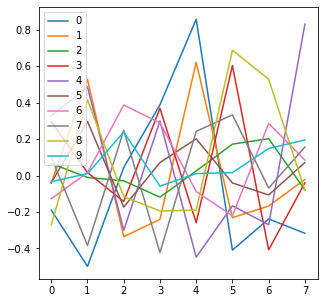

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

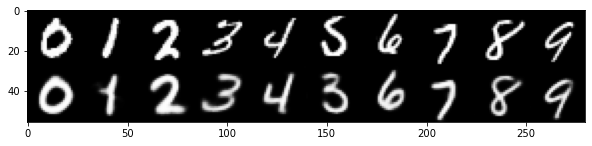

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

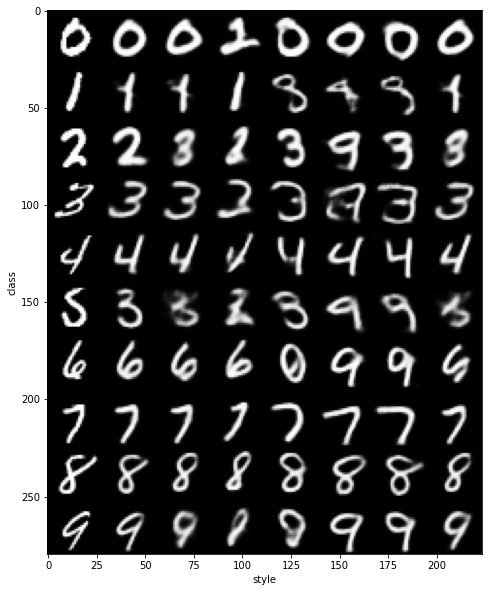

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

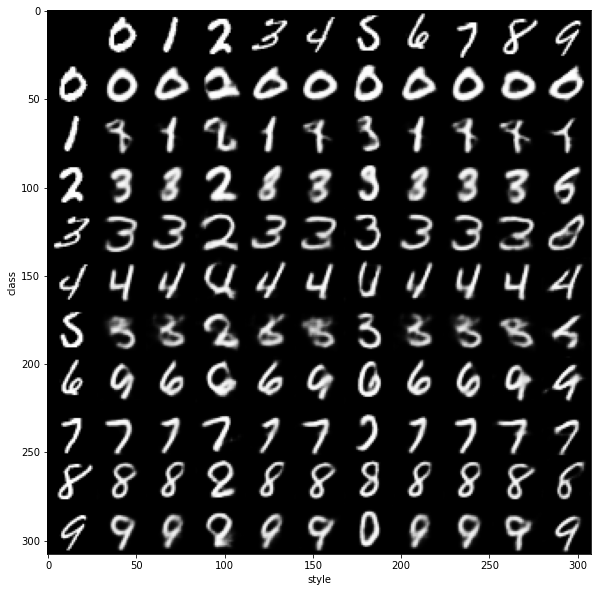

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()